In [142]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
import itertools
from sklearn.linear_model import LinearRegression 
from scipy.stats import t

First thing's first, import the Attendance Register file into a dataframe. 

In [16]:
attendance=pd.read_csv("Attendance Register.csv")

The first two columns of the dataframe are student id and name. Since I am only concerned with overall attendance trends in my class, I'm going to annonymize the data and drop both of these columns. Before doing that, they will be a bit helpful in cleaning the data so we should name them firt. Then I'm going to drop all the rows where the name is null since those rows are either course id's or a key for understanding the "U, A, E" monickers in the date columns. 

In [17]:
attendance=attendance.rename(columns={'Unnamed: 0' : 'id', 'Unnamed: 1': "Name"})

In [18]:
attendance=attendance.drop(attendance[attendance.Name.isna()].index)

In [19]:
attendance=attendance.drop(columns=["id", "Name"])

Just double checking things, but now (aside from the instance of "Student #", which we will change next), the only thing I have is attendance data for students in my roster.

In [20]:
attendance.head()

,08/17/23,08/18/23,08/19/23,08/20/23,08/21/23,08/22/23,08/23/23,08/24/23,08/25/23,08/26/23,...,01/04/24,01/05/24,01/06/24,01/07/24,01/08/24,01/09/24,01/10/24,01/11/24,01/12/24,Unnamed: 151
0,Thu,Fri,Sat,Sun,Mon,Tue,Wed,Thu,Fri,Sat,...,Thu,Fri,Sat,Sun,Mon,Tue,Wed,Thu,Fri,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
3,U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,U,NaN,NaN,NaN,A,NaN,U,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
attendance.columns

Index(['08/17/23', '08/18/23', '08/19/23', '08/20/23', '08/21/23', '08/22/23',
       '08/23/23', '08/24/23', '08/25/23', '08/26/23',
       ...
       '01/04/24', '01/05/24', '01/06/24', '01/07/24', '01/08/24', '01/09/24',
       '01/10/24', '01/11/24', '01/12/24', 'Unnamed: 151'],
      dtype='object', length=150)

There is another column at the end that I missed that is also unnamed. I'm going to renname it to 'unknown' so I can separately access it, and check if it contains anything

In [22]:
attendance=attendance.rename(columns={'Unnamed: 151': 'unknown'})

In [23]:
attendance.unknown

0     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
131   NaN
132   NaN
133   NaN
134   NaN
135   NaN
Name: unknown, Length: 129, dtype: float64

This looks like a lot of NaN's, but I want to make sure so let's do a quick count.

In [24]:
attendance.unknown.count()

0

So basically everything in here is NaN. This may be because this column had information regarding the class code or the absence key, but that's not important for what I'm doing. In any case, it's safe to just drop thie column.

In [25]:
attendance=attendance.drop(columns=['unknown'])

Speaking of, the attendance dataframe uses 'U' for an unexcused absence, 'A' for an excused absence, 'X' for an exempt absence, and '-' for "not on roster on this date". The NaN values are recorded when the student is present. Because I don't want to factors students not on my roster in various computations, it'll be easier to replace the existing NaN values with "P" for present and the '-' values with NaN.

In [26]:
attendance=attendance.fillna('P')
attendance=attendance.replace('-', np.NaN)
attendance['08/19/23'].value_counts()

P      118
Sat      1
Name: 08/19/23, dtype: int64

Just checking here to see what 8/19 looks like, it turns out that this attendance register also recorded weekends and (I presume) holidays. So the next thing is to drop those columns from the dataframe since no one is expecting students to show up on those days.

In [27]:
#Gathering up all of the weekends to drop them from the dataframe
date_list=list(attendance.columns)
weekends=[]
for date in date_list:
    if attendance[date][0] in ['Sat', 'Sun']:
        weekends.append(date)
#Drop all weekends in place
attendance.drop(columns=weekends, inplace=True)

Now we need to drop other days that students were not expected to show. I was just lazy with this and recorded these dates directly from the school calendar.

In [28]:
breaks=["09/04/23", '10/20/23', '10/24/23', '11/22/23', '11/23/23', '11/24/23', '11/27/23', '12/05/23']

In [29]:
breaks.append('12/21/23')
breaks.append('12/22/23')
breaks.append('12/25/23')
breaks.append('12/26/23')
breaks.append('12/27/23')
breaks.append('12/28/23')
breaks.append('12/29/23')
breaks.append('01/01/24')
breaks.append('01/02/24')

In [30]:
#Drop all breaks
attendance.drop(columns=breaks, inplace=True)

In [31]:
attendance.head()

,08/17/23,08/18/23,08/21/23,08/22/23,08/23/23,08/24/23,08/25/23,08/28/23,08/29/23,08/30/23,...,12/19/23,12/20/23,01/03/24,01/04/24,01/05/24,01/08/24,01/09/24,01/10/24,01/11/24,01/12/24
0,Thu,Fri,Mon,Tue,Wed,Thu,Fri,Mon,Tue,Wed,...,Tue,Wed,Wed,Thu,Fri,Mon,Tue,Wed,Thu,Fri
2,P,P,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,U,P,P,P
3,U,P,P,P,P,P,P,P,P,P,...,X,P,P,P,U,P,A,P,U,P
4,P,P,P,P,P,P,P,P,P,P,...,P,U,P,P,P,P,P,P,P,P
5,P,P,P,P,P,P,P,P,P,P,...,X,P,P,P,P,P,P,P,P,P


That looks better in terms of instructional days. Continuing the cleaning, note that we have dates as our columns, but they're represented by strings. In order to better plot time-series data, I'm going to convert the columns to datetime objects.

In [35]:
#Apply a function to the columns to convert them to datetime objects inplace
attendance.rename(columns=lambda x : datetime.strptime(x, "%m/%d/%y"), inplace=True)

Now I want to find how often each student was present, absent, etc. 

In [37]:
student_attendance=attendance.drop([0]).apply(pd.Series.value_counts,axis=1).fillna(0)

In particular, I'm concerned with how often they had excused or unexcused absences. Since I'm only concerned about absences, I will count tardy students as being present.

In [38]:
student_attendance['Excused']=student_attendance[['A','X']].sum(axis=1)

In [39]:
student_attendance.rename(columns={'U': 'Unexcused'}, inplace=True)

In [40]:
student_attendance['Present']=student_attendance[['P','T']].sum(axis=1)

In [41]:
student_attendance_summarized=student_attendance[['Present', 'Excused', 'Unexcused']]

In [42]:
student_attendance_summarized

,Present,Excused,Unexcused
2,79.0,4.0,7.0
3,76.0,4.0,10.0
4,80.0,0.0,10.0
5,87.0,2.0,1.0
6,74.0,5.0,11.0
...,...,...,...
131,79.0,6.0,5.0
132,59.0,12.0,19.0
133,74.0,10.0,6.0
134,87.0,3.0,0.0


Now we want to get an idea of how many students were "chronically absent", which would be those students who miss more than 10% of days. Of course, we can whether we count excused absences as absences for this purpose. From the perspective of the student and determining fault, it may be better to not count excused absences. From the perspective of teaching being easier if the student is in class, it would be better to count excused absences as an absence. So let's do both!

In [43]:
#The percentage of days each student was absent (unexcused)
student_absence_unexcused=(student_attendance_summarized.Unexcused/90)*100

In [44]:
student_absence_unexcused.sort_values(ascending=False)

29     28.888889
48     27.777778
132    21.111111
108    20.000000
59     20.000000
         ...    
77      0.000000
129     0.000000
7       0.000000
134     0.000000
36      0.000000
Name: Unexcused, Length: 128, dtype: float64

In [45]:
student_absence_unexcused[student_absence_unexcused>10.0].count()

32

This tells me that 32 of my students would have been considered chronically absent for my class during the first semester. I have 128 students on my roster, which means a quarter of my students were chronically absent! Now let's look at absences in general.

In [46]:
student_absence=(1-student_attendance_summarized.Present/90)*100

In [47]:
student_absence[student_absence>10.0].count()

57

Okay, so 57 of my 128 students (45%) missed at least 10% of the instructional time! Regardless of why that happened, this makes it difficult to actually make progress in class. Let's take a look at some summary statistics for both series.

In [48]:
student_absence.describe()

count    128.000000
mean      11.449653
std        8.437303
min        0.000000
25%        5.555556
50%        9.444444
75%       16.666667
max       45.555556
Name: Present, dtype: float64

In [49]:
student_absence_unexcused.describe()

count    128.000000
mean       7.083333
std        5.807917
min        0.000000
25%        2.222222
50%        5.555556
75%       10.277778
max       28.888889
Name: Unexcused, dtype: float64

The next thing I want to do is look at how many students are absent (just unexcused and absent in general) on my roster on each day. For this, we just need to count values across columns.

In [50]:
#For each date, count the number of students who are present or tardy to 
#get the number of folks who were present on that day.
present_bydate=((attendance=='P') | (attendance=='T')).sum()

In [51]:
#For each date, count the number of students who are absent (unexcused) on a given day.
unexcused_bydate=(attendance=='U').sum()

In [52]:
present_bydate

2023-08-17    115
2023-08-18    117
2023-08-21    112
2023-08-22    113
2023-08-23    116
             ... 
2024-01-08    118
2024-01-09    107
2024-01-10    118
2024-01-11    116
2024-01-12    116
Length: 90, dtype: int64

In [53]:
unexcused_bydate

2023-08-17     2
2023-08-18     1
2023-08-21     6
2023-08-22     4
2023-08-23     3
              ..
2024-01-08    10
2024-01-09    13
2024-01-10     7
2024-01-11     9
2024-01-12     9
Length: 90, dtype: int64

In [54]:
#percent of roster that is absent (unexcused)
unexcused_percent_bydate=unexcused_bydate.apply(lambda x : 100*(x/128))

In [55]:
unexcused_percent_bydate

2023-08-17     1.56250
2023-08-18     0.78125
2023-08-21     4.68750
2023-08-22     3.12500
2023-08-23     2.34375
                ...   
2024-01-08     7.81250
2024-01-09    10.15625
2024-01-10     5.46875
2024-01-11     7.03125
2024-01-12     7.03125
Length: 90, dtype: float64

Now we want to get a look at what the attendance looks like throughout the semester in my classes. We'll look at both unexcused absences and absences in general.

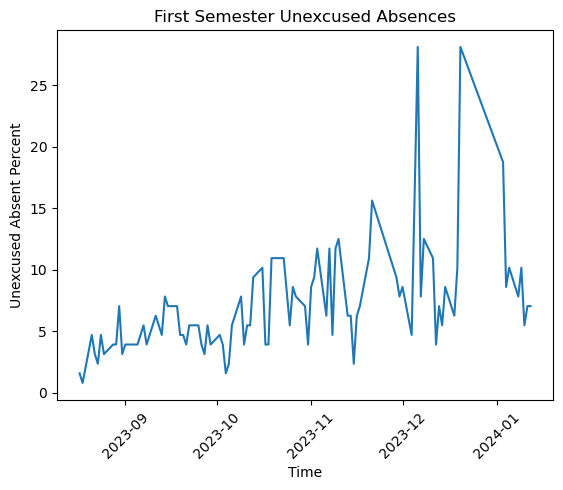

In [56]:
#Time-series graph of percent of unexcused absences during first semester.
plt.plot(unexcused_percent_bydate)
# Add title and axis labels
plt.title('First Semester Unexcused Absences')
plt.xlabel('Time')
plt.ylabel('Unexcused Absent Percent')
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [57]:
absent_bydate=128-present_bydate
absent_percent_bydate=100*(absent_bydate/128)

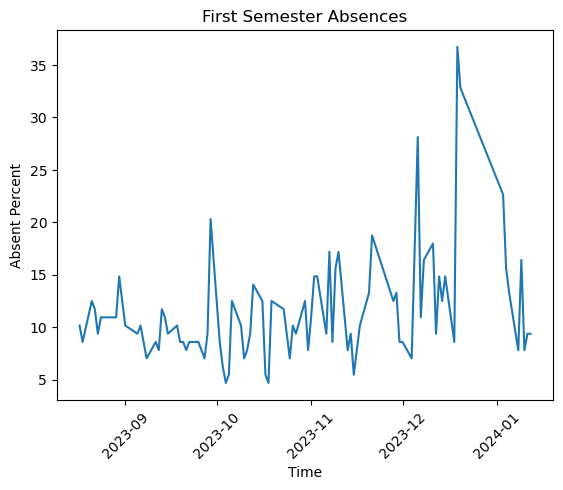

In [58]:
plt.plot(absent_percent_bydate)
# Add title and axis labels
plt.title('First Semester Absences')
plt.xlabel('Time')
plt.ylabel('Absent Percent')
plt.xticks(rotation=45)

# Display the plot
plt.show()

Now we're going to grab some summary statistics to see if anything really stands out

In [59]:
absent_percent_bydate.describe()

count    90.000000
mean     11.449653
std       5.307956
min       4.687500
25%       8.593750
50%      10.156250
75%      12.500000
max      36.718750
dtype: float64

In [60]:
unexcused_percent_bydate.describe()

count    90.000000
mean      7.083333
std       4.511258
min       0.781250
25%       3.906250
50%       6.250000
75%       8.593750
max      28.125000
dtype: float64

Now I'm curious as to whether or not there are trends in the data in regards to days of the week. For example, are students more likely to miss Firday or Monday?

In [61]:
attendance.iloc[0]

2023-08-17    Thu
2023-08-18    Fri
2023-08-21    Mon
2023-08-22    Tue
2023-08-23    Wed
             ... 
2024-01-08    Mon
2024-01-09    Tue
2024-01-10    Wed
2024-01-11    Thu
2024-01-12    Fri
Name: 0, Length: 90, dtype: object

In [62]:
#create an array of the days of the weeks in date order
day_array=attendance.iloc[0].to_numpy()

In [63]:
#create an array of the present data in date order
present_array=present_bydate.to_numpy()

In [64]:
#create an array of unexcused absence data in date order
unexcused_array=unexcused_bydate.to_numpy()

Now we're going to make a dataframe that uses the dates as indeces, and has a column fo the day of the week, number of present students, and number of absent students.

In [65]:
d={'day': day_array, 'present' : present_array, 'unexcused' : unexcused_array}
attendance_days=pd.DataFrame(data=d, index=unexcused_bydate.index)

In [66]:
#create a dictionary to store the days of the week
day_dict={}
for wday in set(attendance_days.day.values):
    #zero out attendance for any date that does not correspond to the day we're considering
    day_present=attendance_days.present*(attendance_days.day==wday)
    #eliminate all 0 values
    day_dict[wday]=day_present[day_present.to_numpy().nonzero()[0]]

In [67]:
#End result is a dictionary that partitions the dates into days of the week.
day_dict

{'Thu': 2023-08-17    115
 2023-08-24    114
 2023-08-31    112
 2023-09-07    117
 2023-09-14    114
 2023-09-21    118
 2023-09-28    116
 2023-10-05    121
 2023-10-12    116
 2023-10-19    112
 2023-10-26    115
 2023-11-02    109
 2023-11-09    108
 2023-11-16    118
 2023-11-30    117
 2023-12-07    114
 2023-12-14    112
 2024-01-04    108
 2024-01-11    116
 dtype: int64,
 'Fri': 2023-08-18    117
 2023-08-25    114
 2023-09-01    115
 2023-09-08    119
 2023-09-15    116
 2023-09-22    117
 2023-09-29    102
 2023-10-06    112
 2023-10-13    110
 2023-10-27    116
 2023-11-03    109
 2023-11-10    106
 2023-11-17    115
 2023-12-01    117
 2023-12-08    107
 2023-12-15    109
 2024-01-05    111
 2024-01-12    116
 dtype: int64,
 'Wed': 2023-08-23    116
 2023-08-30    109
 2023-09-06    115
 2023-09-13    113
 2023-09-20    117
 2023-09-27    119
 2023-10-04    122
 2023-10-11    118
 2023-10-18    122
 2023-10-25    119
 2023-11-01    114
 2023-11-08    117
 2023-11-15    121

In [68]:
#Do the same for unexcused absences
day_dict_u={}
for wday in set(attendance_days.day.values):
    day_u=attendance_days.unexcused*(attendance_days.day==wday)
    day_dict_u[wday]=day_u[day_u.to_numpy().nonzero()[0]]

In [69]:
#Check summary statistics to see if there are any noticeable trends.
for wday in day_dict_u:
    print(wday, day_dict_u[wday].describe(), sep='\n')

Thu
count    19.000000
mean      8.315789
std       3.528497
min       2.000000
25%       6.500000
50%       8.000000
75%      10.500000
max      15.000000
dtype: float64
Fri
count    18.000000
mean      9.166667
std       4.287465
min       1.000000
25%       5.500000
50%       9.000000
75%      11.750000
max      16.000000
dtype: float64
Wed
count    19.000000
mean     10.473684
std      10.178236
min       2.000000
25%       5.500000
50%       7.000000
75%      10.000000
max      36.000000
dtype: float64
Mon
count    17.000000
mean      9.117647
std       2.997548
min       5.000000
25%       7.000000
50%       8.000000
75%      10.000000
max      14.000000
dtype: float64
Tue
count    17.000000
mean      8.176471
std       4.746516
min       4.000000
25%       5.000000
50%       5.000000
75%      13.000000
max      20.000000
dtype: float64


One thing that immediately pops out is Wednesday with it's fairly high standard deviation relative to the other days as well as the relatively higher mean. We can see from the data that Wednesday was one of those large spikes in absences that we saw near the end of the semester. Next, we wanto to visually compare the data. As the data is stored, this would yield timeseries graphs, but that may not be the best way to view the data.

Text(0.5, 0, 'Date')

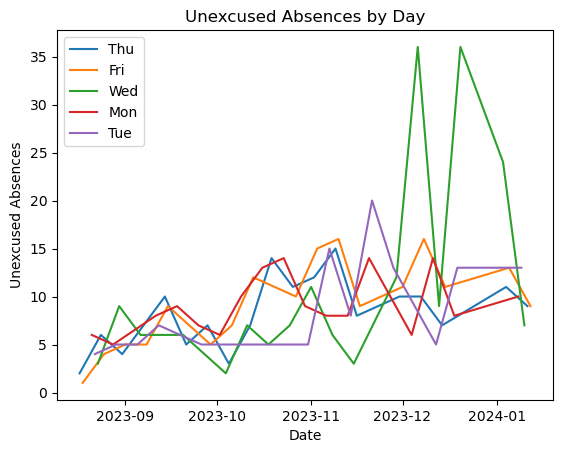

In [70]:
for wday in day_dict_u:
    plt.plot(day_dict_u[wday], label=wday)
plt.legend(loc="upper left")
plt.title('Unexcused Absences by Day')
plt.ylabel('Unexcused Absences')
plt.xlabel('Date')

We see the predicted spike, but the problem here is date may not be the best way to group these observations. A better method may be to group the date by which school week it is. This would also acount for the facts that we did not meet on every day of every week (so some school weeks will only include a subset of the weekdays). 

In [76]:
#Set the initial day to Sunday of the first week of school
week=timedelta(weeks=1)
initial=datetime(2023, 8, 13)

Now we're going to create a "school week" array to associate to each date. That will allow us to create a new dataframe with the school week as our index and days of the week as the columns.

In [77]:
weekdays=['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
w_n=0
weeknum=[]
date_check=initial
for date in attendance_days.index:
    #check if the date is within the week
    if date<=date_check:
        weeknum.append(w_n)
    #if it isn't, keep incrementing the check date by a week until we end up at the appropriate week
    else:
        while date>date_check:
            w_n+=1
            date_check+=week
        weeknum.append(w_n)

attendance_days["week number"]=weeknum

In [78]:
#Join the week number to each day's unexpected absence series and make it a dataframe in the process
unex_weeknum={}
for wday in weekdays:
    unex_weeknum[wday]=day_dict_u[wday].rename(wday).to_frame().join(attendance_days["week number"].to_frame())

In [79]:
#set the index of each weekday dataframe to its week number
for wday in weekdays:
    unex_weeknum[wday].set_index("week number", inplace=True)

In [80]:
#join all of the individual days of the week into a dataframe that organizes absences by school week
unexcused_by_week=unex_weeknum["Mon"].join(unex_weeknum["Tue"], how="outer")
unexcused_by_week=unexcused_by_week.join(unex_weeknum["Wed"], how="outer")
unexcused_by_week=unexcused_by_week.join(unex_weeknum["Thu"], how="outer")
unexcused_by_week=unexcused_by_week.join(unex_weeknum["Fri"], how="outer")

In [81]:
unexcused_by_week["Total"]=unexcused_by_week.sum(axis=1)

In [91]:
x=np.linspace(1,22, num=21)
y=unexcused_by_week.mean(axis=1)

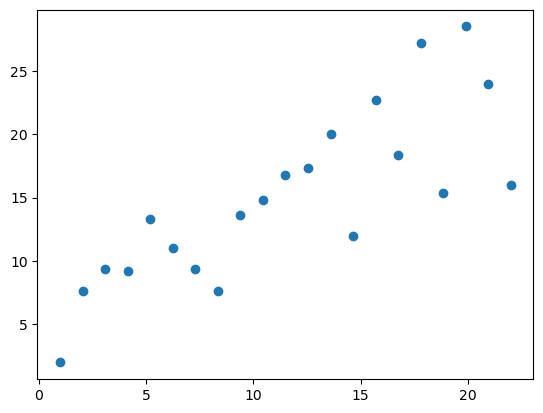

In [92]:
plt.scatter(x, y)

Interestingly enough, the scatterplot by week does suggest a linear relation moreso than the original timeseries data. Though, the statement "students tend to miss more school as the semester drags on" isn't exactly news.

In [93]:
x=pd.DataFrame(x)
reg=LinearRegression().fit(x,y)
reg.score(x,y)

0.6615357991354229

In [94]:
#create an array of x-values so we can apply the slope and intercept above.
y_pred=x*reg.coef_+reg.intercept_

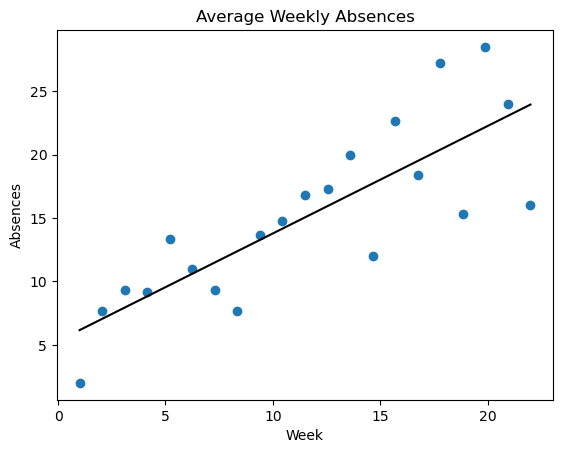

In [95]:
#recreate the scatter plot, but now with the line of best fit.
plt.scatter(x,y)
plt.plot(x, y_pred, color='black')
plt.title('Average Weekly Absences')
plt.xlabel('Week')
plt.ylabel('Absences')


plt.show()

Now, let's go ahead and test the significance of the relationship between the week and absences. In particular, we're going to use the slop $\beta_1$ to test this relationship.

$H_0: \beta_1=0$

$H_a:\beta_1\neq 0$

The first step is to compute the residual sum of squares (RSS).

In [147]:
#We have to send y and y_pred to arrays before zipping and using list comprehension
RSS=sum([(yi-y_hat)**2 for yi, y_hat in zip(y.to_numpy(), y_pred.to_numpy())])[0]
RSS

311.7811159211159

Since we don't know our population standard deviaion ($\sigma$), we estimate it with the residual standard error (RSE) in order to compute the test statistic.

In [121]:
RSE=math.sqrt(RSS/(len(x)-2))
RSE

4.050868106579235

Assuming the null hypothesis, we compute the test-statistic noting that we're testing with the t-distribution with $n-2$ degrees of freedom due to the small number of points.

In [148]:
#The t-value is just beta_1 divided by the standard error.
sqr_dev=(x-x.mean())**2
SE=RSE/math.sqrt(sqr_dev.sum())
t_val=reg.coef_/SE
t_val[0]

6.093925012706526

Finally, we compute the p-value using the t-distribution from the scipy.stats library. Since we're doing a two-tailed test, we need the sum of both tails.

In [146]:
p=(1-t.cdf(t_val[0], len(x)-2))*2
print(p)

7.360233132303051e-06


We can very safely reject the null hypothesis here to conclude that it's highly likely that attendance is correlated with how far one is into the school year. Of course, we could have intuitively concluded that from the strength of the correlation and the value of $\beta_1$, but I had never done hypothesis testing in Python. So I figured this would be a nice motivator.

Now that we have our data arranged by school weeks and weekdays, we can now create a stacked bar chart where the x-axis is the school week and the stacked bars correspond to days of the week.

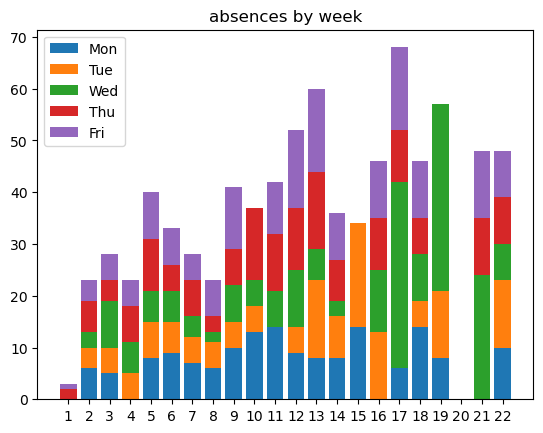

In [318]:
fig, ax = plt.subplots()
bottom=np.zeros(21)

bar_dict={}

#create a dictionary of values for each weekday so we can easily set the bar height
for wday in weekdays:
    bar_dict[wday]=unexcused_by_week[wday].values
    
for wday in bar_dict:
    ax.bar(unexcused_by_week.index, bar_dict[wday], bottom=bottom, label=wday)
    bottom+=np.nan_to_num(bar_dict[wday])

ax.set_title("absences by week")
ax.legend(loc="upper left")
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

plt.show()

For fun, let's just compute the R^2 for simple linear regression on each pair of weekday absences.

In [343]:
weekday_pairs=list(filter( lambda p : p[0]!=p[1], list(itertools.product(weekdays, weekdays))))

In [348]:
unexcused_by_week_filled=unexcused_by_week

In [349]:
for wday in weekdays:
    wday_mean=unexcused_by_week_filled[wday].mean()
    unexcused_by_week_filled[wday].fillna(wday_mean, inplace=True)


In [351]:
for p in weekday_pairs:
    x=unexcused_by_week_filled[[p[0]]]
    y=unexcused_by_week_filled[p[1]]
    reg=LinearRegression().fit(x,y)
    print(p, reg.score(x,y))

('Mon', 'Tue') 0.07705954444912444
('Mon', 'Wed') 0.01898137947321843
('Mon', 'Thu') 0.10530594708424923
('Mon', 'Fri') 0.02760387236181938
('Tue', 'Mon') 0.07705954444912477
('Tue', 'Wed') 0.07770409094755248
('Tue', 'Thu') 0.09927040625414885
('Tue', 'Fri') 0.07914483267632555
('Wed', 'Mon') 0.01898137947321865
('Wed', 'Tue') 0.07770409094755226
('Wed', 'Thu') 0.029153147497669618
('Wed', 'Fri') 0.161875592792311
('Thu', 'Mon') 0.1053059470842489
('Thu', 'Tue') 0.09927040625414907
('Thu', 'Wed') 0.029153147497669507
('Thu', 'Fri') 0.5654628464067637
('Fri', 'Mon') 0.027603872361820048
('Fri', 'Tue') 0.07914483267632555
('Fri', 'Wed') 0.161875592792311
('Fri', 'Thu') 0.5654628464067637


Funnily enough, there seems to be little relationship between absences on most days of the week. That is, there does not seem to be a strong linear relationship between absences on e.g. Monday and Tuesday of a given week. It is somewhat funny that there is such a relationship between absences on Thursdays Fridays. 